# Análise Bivariada
Inicialmente faça uma análise bivariada de sintomas de depressão (`phq9` ou `phq_grp`) com as características demográficas. Descreva o perfil com maiores incidências de sintomas de depressão.

Depois faça uma análise bivariada de características demográficas x hábitos saudáveis. **Qual perfil possui hábitos mais saudáveis?**

Por fim, faça uma análise bivariada de sintomas de depressão (`phq9` ou `phq_grp`) com os hábitos saudáveis (variáveis de atividade física e healthy eating index). **O que podemos observar?**

## Inicialização

### Importando pacotes e carregando dados

In [1]:
import math
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
from scipy.stats import shapiro
import seaborn as sns

import utils  # Funções auxiliares para a análise

# Oculta warnings do notebook
import warnings
warnings.filterwarnings('ignore')

# Configurações para facilitar a visualização dos dataframes
pd.set_option('display.max_rows', 35)
pd.set_option('display.max_columns', 50)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# Carregando dados pré-processados
dataset_path = '../data/output/'
dataset_name = 'step_2_output.csv'

df = pd.read_csv(f"{dataset_path}{dataset_name}")

In [9]:
# Indicando categorias com ordenação
USE_CATEGORIES = False

if USE_CATEGORIES:
    df['PHQ_GRP'] = pd.Categorical(
        df['PHQ_GRP'], ['sem sint', 'lev', 'mod-sev',]
    )

    df['DMDEDUC'] = pd.Categorical(
        df['DMDEDUC'], ['< 9', '9 - 12', 'Ens Med', 'Sup Incomp', 'Supr Comp']
    )

    df['INDFMINC_GRP'] = pd.Categorical(
        df['INDFMINC_GRP'], [
            '< 5k', '5k - 10k', '10k - 15k', '15k - 20k', '20k - 25k', 
            '25k - 35k', '35k - 45k', '45k - 55k', '55k - 65k', '65k - 75k', '> 75k'
        ]
    )

    df['INDFMINC_ABV20K'] = pd.Categorical(
        df['INDFMINC_ABV20K'], ['< 20k', '> 20k']
    )

    df['ADHERENCE'] = pd.Categorical(
        df['ADHERENCE'], ['baixo', 'adeq', 'acima',]
    )

In [3]:
# Separando colunas de acordo com suas origens
def split_columns_by_source(columns, step=1):
    is_phq_column = lambda x: True if (x.find('DPQ') > -1) else False
    phq_cols = [col for col in columns if is_phq_column(col)]
    
    is_hei_column = lambda x: True if (x.find('HEI2015') > -1) else False
    hei_cols = [col for col in columns if is_hei_column(col)]
    
    demo_cols = ['RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDEDUC', 'INDFMINC', 'INDFMINC_ABV20K', 'INDFMINC_GRP']
    pag_cols = ['PAG_MINW', 'ADHERENCE']
    phq_score_cols = ['PHQ9', 'PHQ_GRP']
    
    return demo_cols, phq_cols, hei_cols, pag_cols, phq_score_cols


demo_cols, phq_cols, hei_cols, pag_cols, phq_score_cols = split_columns_by_source(df.columns)

quanti_cols = ['RIDAGEYR', 'INDFMINC', 'PHQ9', 'PAG_MINW'] + phq_cols + hei_cols
quali_cols = ['RIAGENDR', 'RIDRETH1', 'DMDEDUC', 'INDFMINC_ABV20K', 'PHQ_GRP', 'ADHERENCE']

print('DEMO:', demo_cols)
print('PHQ:', phq_cols)
print('PHQ Scores:', phq_score_cols)
print('HEI:', hei_cols)
print('PAG:', pag_cols)

print('Quanti:', quanti_cols)
print('Quali:', quali_cols)

DEMO: ['RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDEDUC', 'INDFMINC', 'INDFMINC_ABV20K', 'INDFMINC_GRP']
PHQ: ['DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050', 'DPQ060', 'DPQ070', 'DPQ080', 'DPQ090']
PHQ Scores: ['PHQ9', 'PHQ_GRP']
HEI: ['HEI2015C1_TOTALVEG', 'HEI2015C2_GREEN_AND_BEAN', 'HEI2015C3_TOTALFRUIT', 'HEI2015C4_WHOLEFRUIT', 'HEI2015C5_WHOLEGRAIN', 'HEI2015C6_TOTALDAIRY', 'HEI2015C7_TOTPROT', 'HEI2015C8_SEAPLANT_PROT', 'HEI2015C9_FATTYACID', 'HEI2015C10_SODIUM', 'HEI2015C11_REFINEDGRAIN', 'HEI2015C12_SFAT', 'HEI2015C13_ADDSUG', 'HEI2015_TOTAL_SCORE']
PAG: ['PAG_MINW', 'ADHERENCE']
Quanti: ['RIDAGEYR', 'INDFMINC', 'PHQ9', 'PAG_MINW', 'DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050', 'DPQ060', 'DPQ070', 'DPQ080', 'DPQ090', 'HEI2015C1_TOTALVEG', 'HEI2015C2_GREEN_AND_BEAN', 'HEI2015C3_TOTALFRUIT', 'HEI2015C4_WHOLEFRUIT', 'HEI2015C5_WHOLEGRAIN', 'HEI2015C6_TOTALDAIRY', 'HEI2015C7_TOTPROT', 'HEI2015C8_SEAPLANT_PROT', 'HEI2015C9_FATTYACID', 'HEI2015C10_SODIUM', 'HEI2015C11_REFINEDGRAIN'

## Funções Auxiliares

In [28]:
def quali_comparison(df, col, quali_ref=None, quanti_ref=None):
    fig, ax = plt.subplots(1, 3, figsize=(16, 4), squeeze=False)
    plt.suptitle('Coluna Qualitativa: ' + col)
    
    if quanti_ref:
        sns.boxplot(
            data=df,
            x=col,
            y=quanti_ref,
            ax=ax[0][0],
        )
        
    if quali_ref:
        sns.histplot(
            data=df,
            x=col,
            hue=quali_ref,
            stat='proportion',
            multiple='dodge',
            shrink=0.7,
            ax=ax[0][1],
        )
    
    if quanti_ref:
        sns.histplot(
            data=df,
            x=quanti_ref,
            hue=col,
            # stat='proportion',
            multiple='stack',
            kde=True,
            discrete=True,
            ax=ax[0][2],
        )

# quali_comparison(df, 'RIAGENDR', 'PHQ_GRP', 'PHQ9')

In [27]:
def quanti_comparison(df, col, quali_ref, quanti_ref):
    fig, ax = plt.subplots(1, 3, figsize=(16, 4), squeeze=False)
    plt.suptitle('Coluna Qualitativa: ' + col)
    
    if quali_ref:
        sns.boxplot(
            data=df,
            x=quali_ref,
            y=col,
            ax=ax[0][0]
        )
    
        sns.histplot(
            data=df,
            x=col,
            # y=quanti_ref,
            hue=quali_ref,
            # stat='proportion',
            multiple='stack',
            kde=True,
            ax=ax[0][1],
        )
    
        if quanti_ref:
            sns.scatterplot(
                data=df,
                x=col,
                y=quanti_ref,
                # hue=quali_ref,
                ax=ax[0][2]
            )

In [ ]:
# Definindo variáveis para comparação
quanti_ref = 'PHQ9'
quali_ref = 'PHQ_GRP'

### Outros experimentos

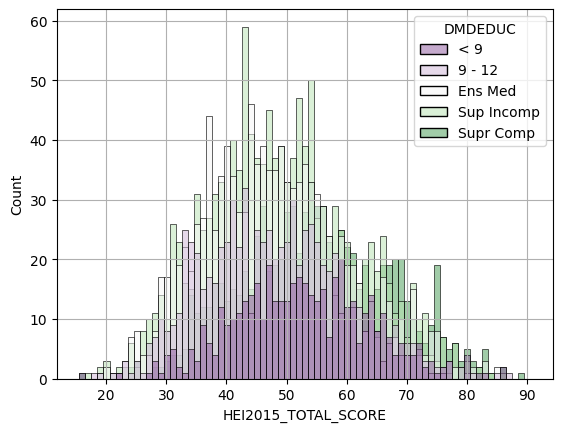

In [6]:
sns.histplot(
    x=df.HEI2015_TOTAL_SCORE, 
    hue=df.DMDEDUC, 
    discrete=True, 
    palette='PRGn'
)
plt.grid()

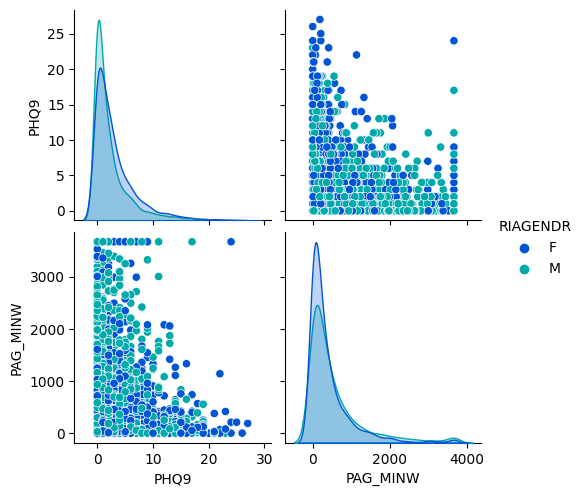

In [174]:
sns.pairplot(
    df,
    hue='RIAGENDR',
    palette='winter',
    vars=['PHQ9','PAG_MINW']
) 

<AxesSubplot: xlabel='RIDRETH1', ylabel='PHQ9'>

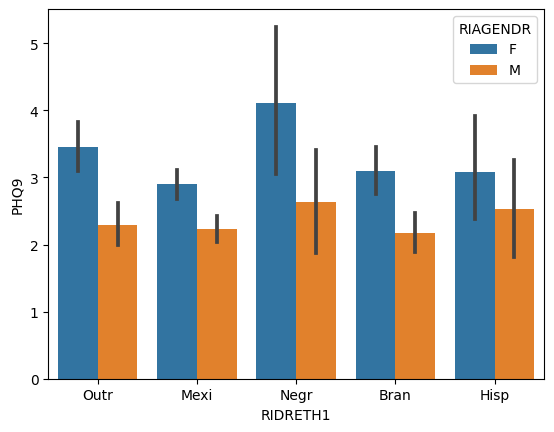

In [173]:
sns.barplot(
    data=df,
    x='RIDRETH1',
    y='PHQ9',
    hue='RIAGENDR',
)   

## Variáveis Qualitativas

In [ ]:
# Analisando correlações de Spearman entre as variáveis qualitativas
# Não está funcionando pois esta correlação só funciona para dados numéricos (e não object ou category), mesmo que representem categorias

# sns.set(rc={'figure.figsize':(12,9)})
# sns.set(font_scale=0.5)

# quali_df = df[quali_cols]

# sns.heatmap(
#     quali_df.corr(method="spearman"),
#     annot=True, fmt='.2f',
#     cmap='PRGn', vmin=-1, vmax=1,
#     mask=np.triu(np.ones_like(quali_df.corr()))
# )

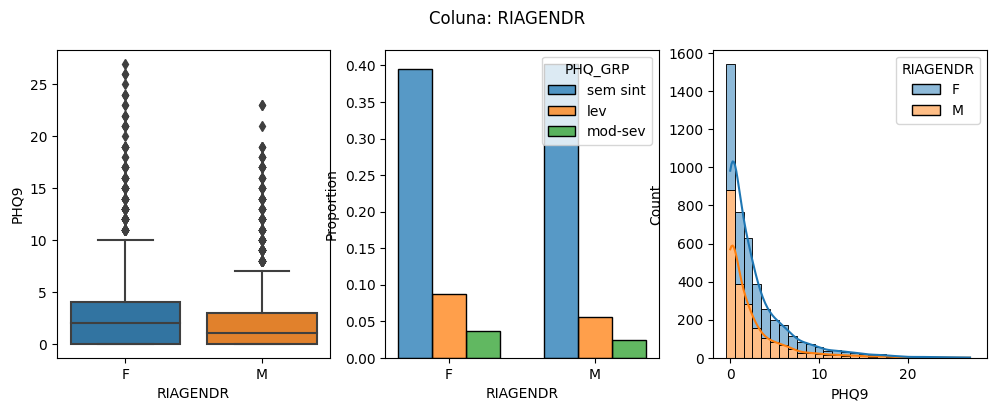

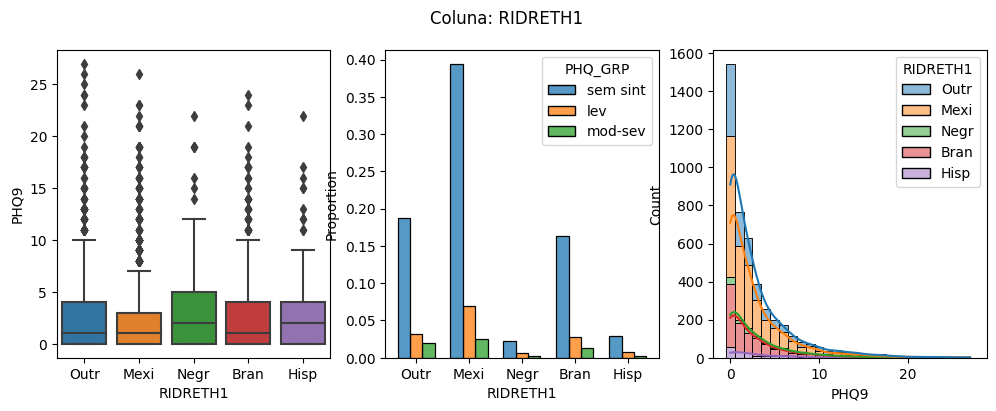

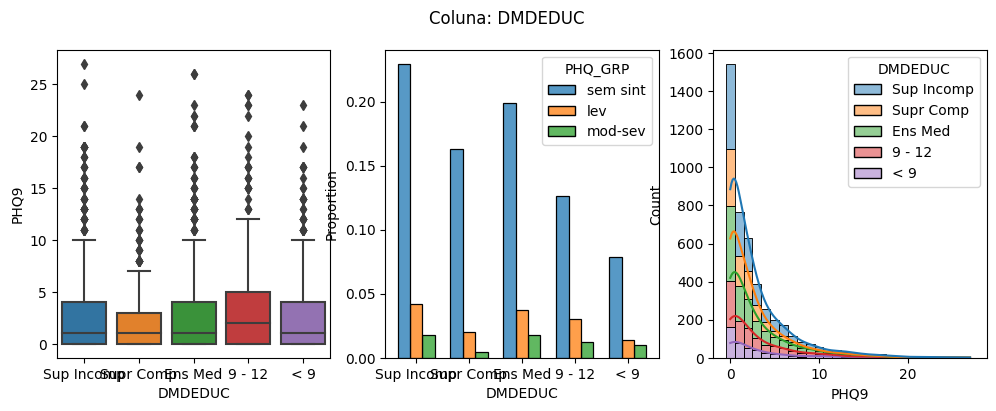

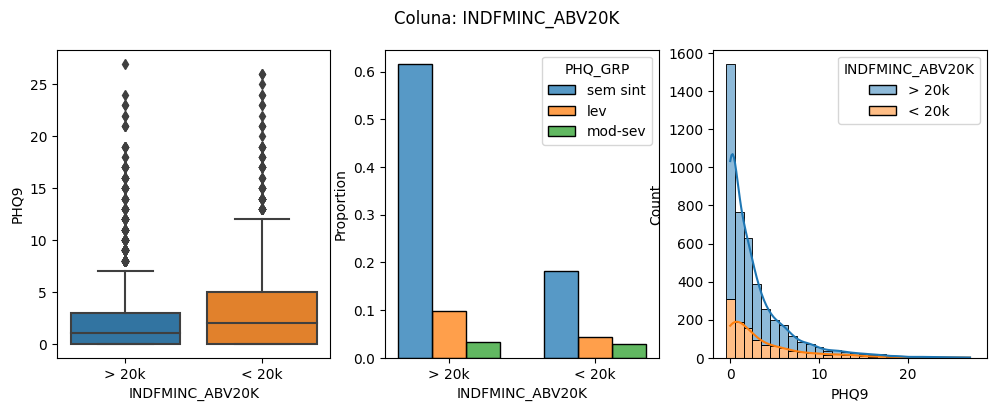

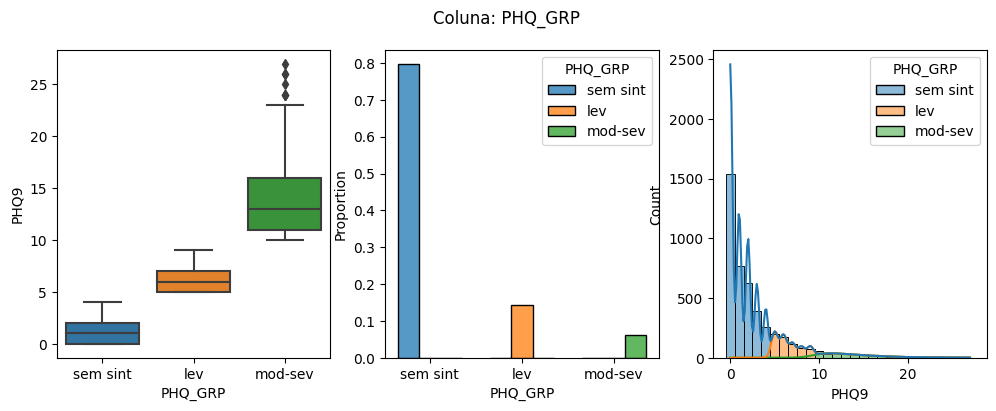

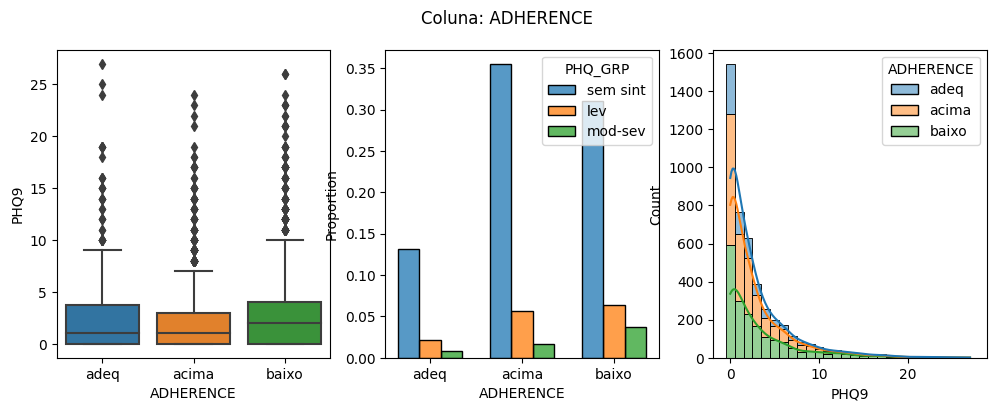

In [16]:
for col in quali_cols:
    quali_comparison(df, col, quali_ref, quanti_ref)

## Variáveis Quantitativas

<AxesSubplot: >

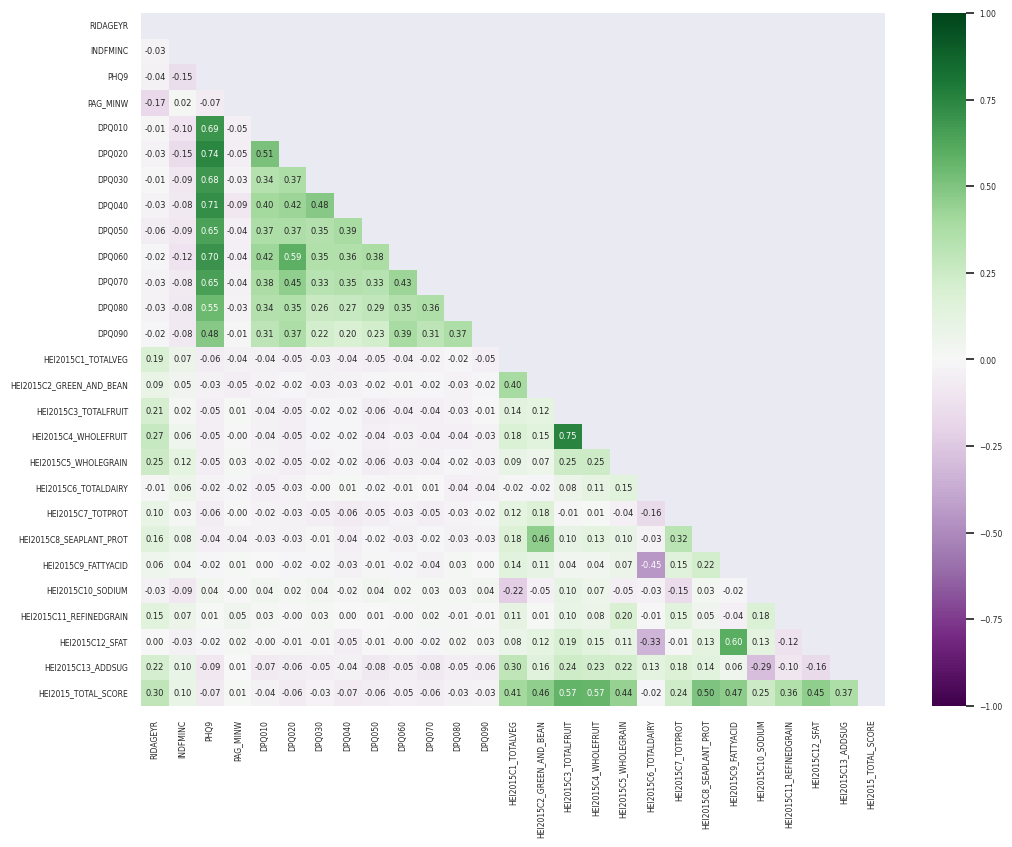

In [31]:
# Analisando correlações entre as variáveis quantitativas
sns.set(rc={'figure.figsize':(12,9)})
sns.set(font_scale=0.5)

quanti_df = df[quanti_cols]

sns.heatmap(
    quanti_df.corr(),
    annot=True, fmt='.2f',
    cmap='PRGn', vmin=-1, vmax=1,
    mask=np.triu(np.ones_like(quanti_df.corr()))
)

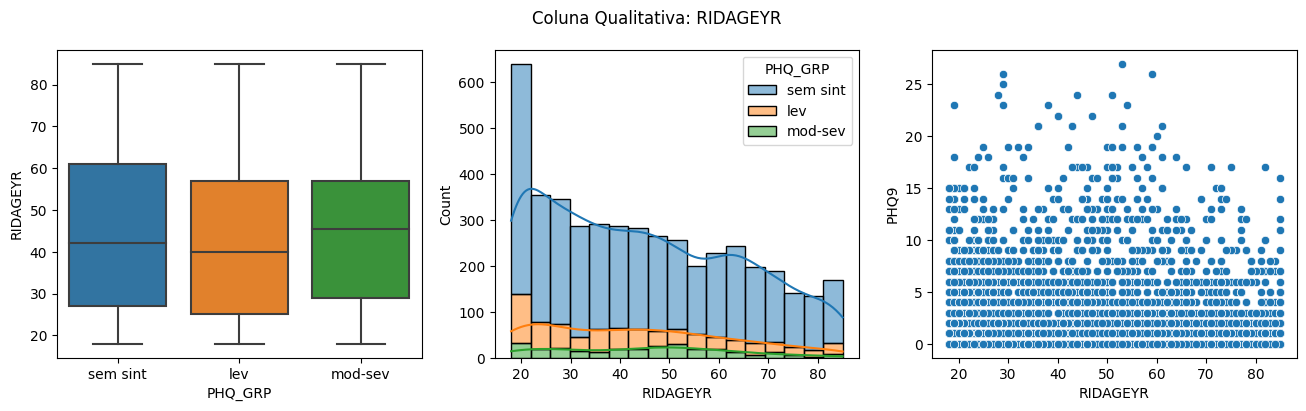

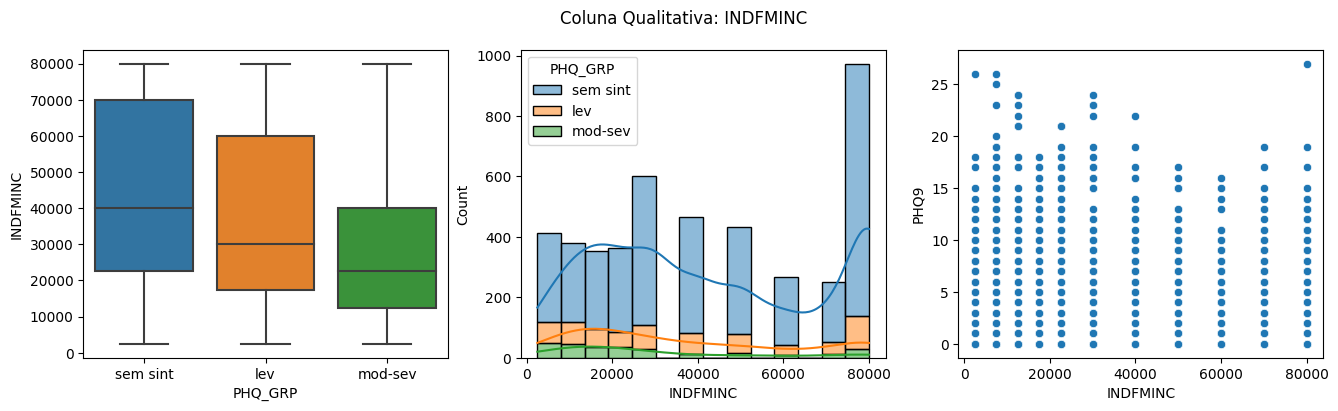

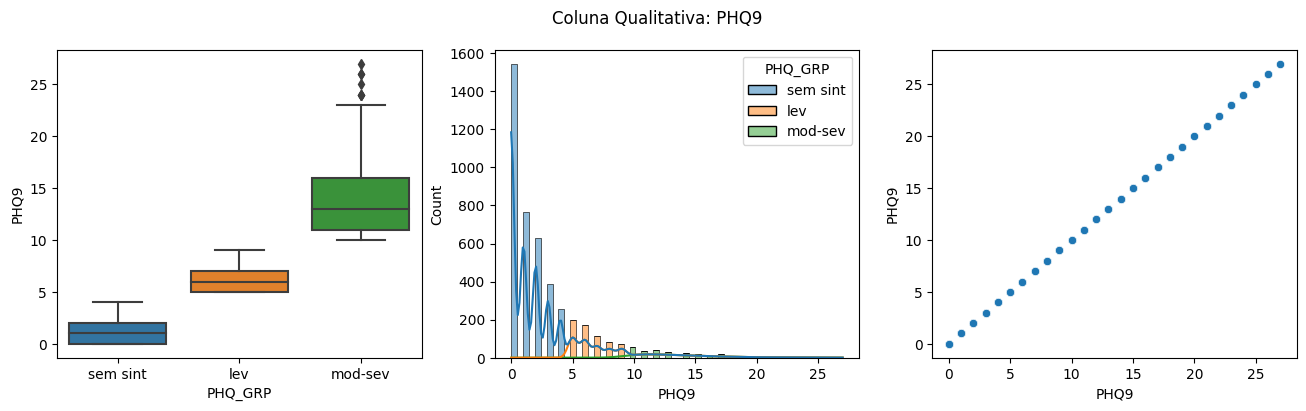

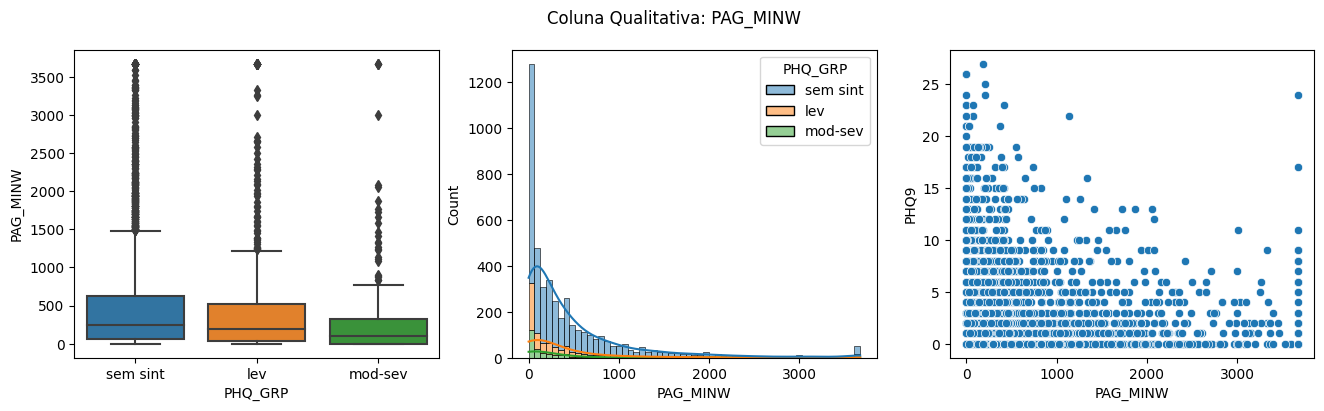

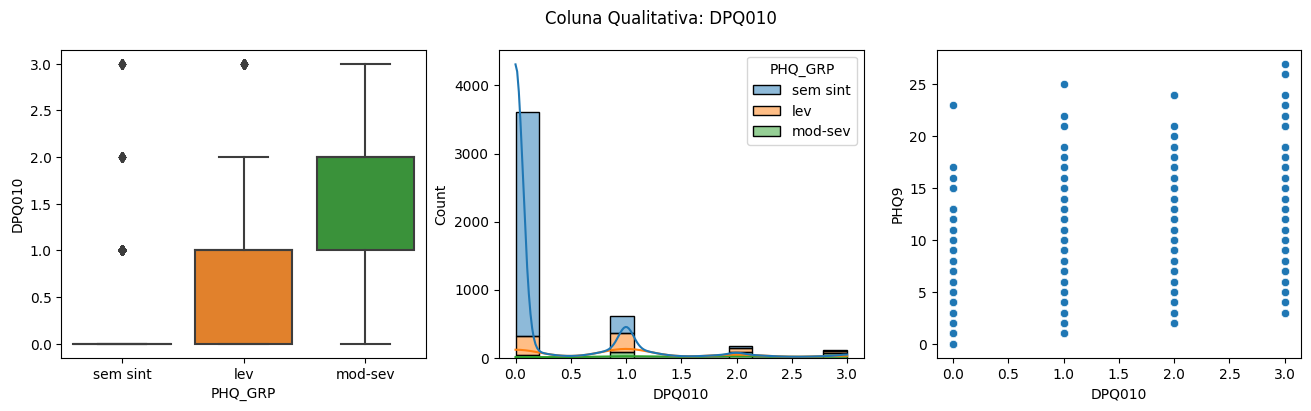

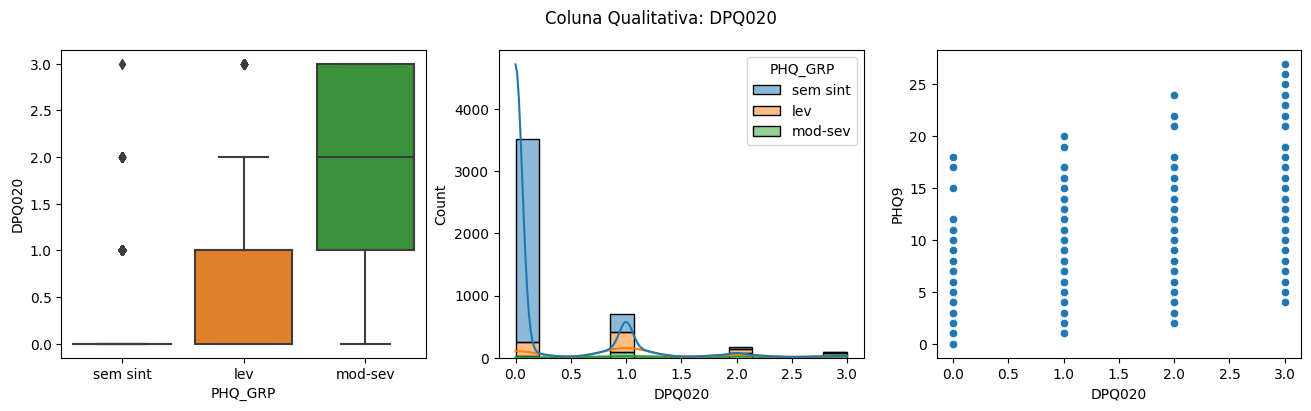

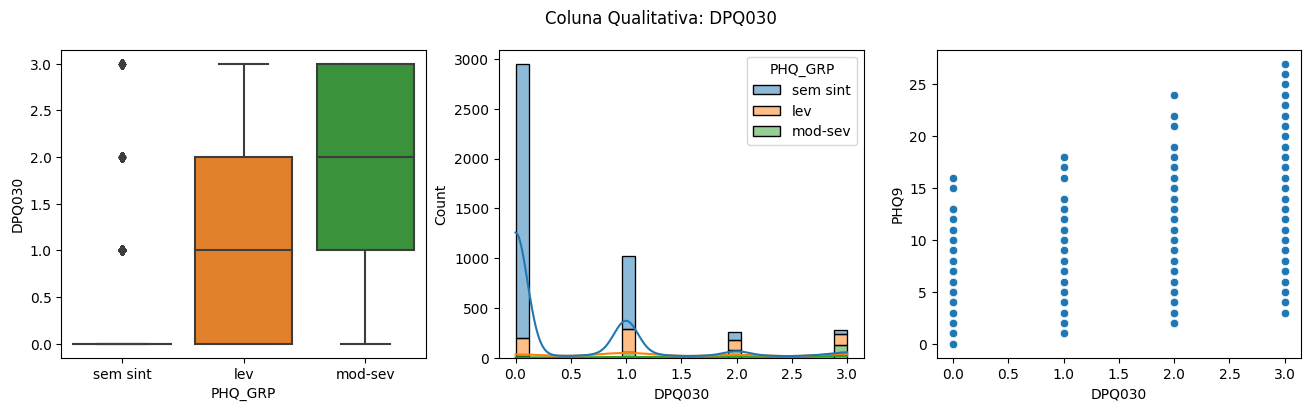

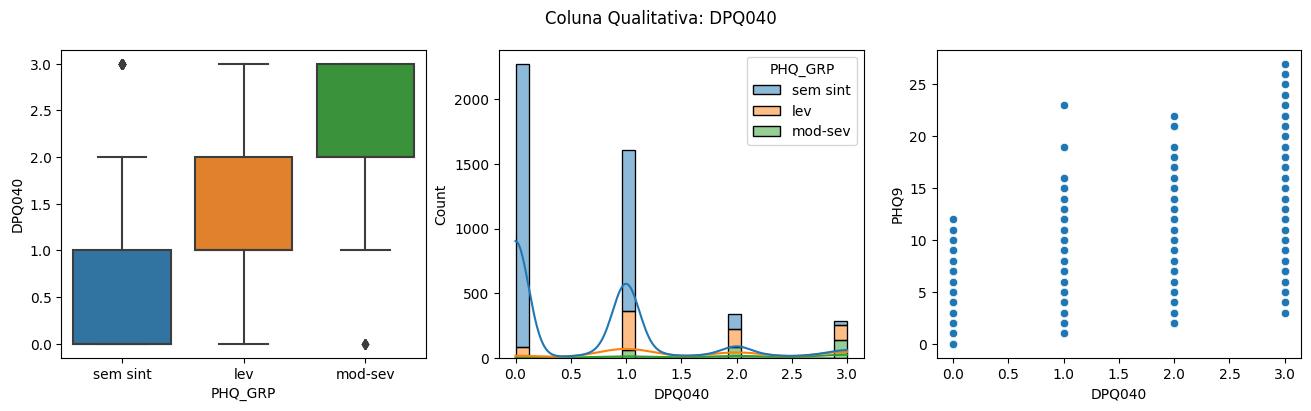

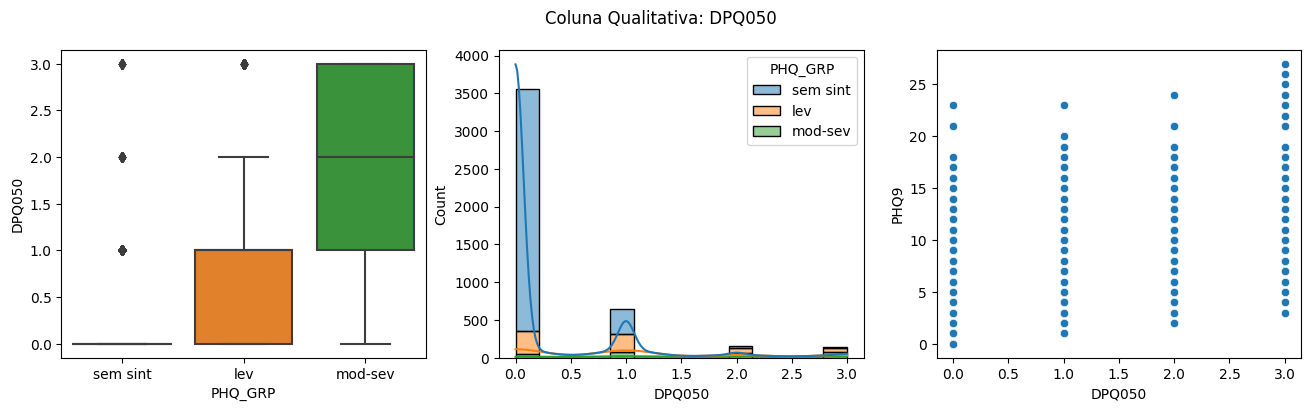

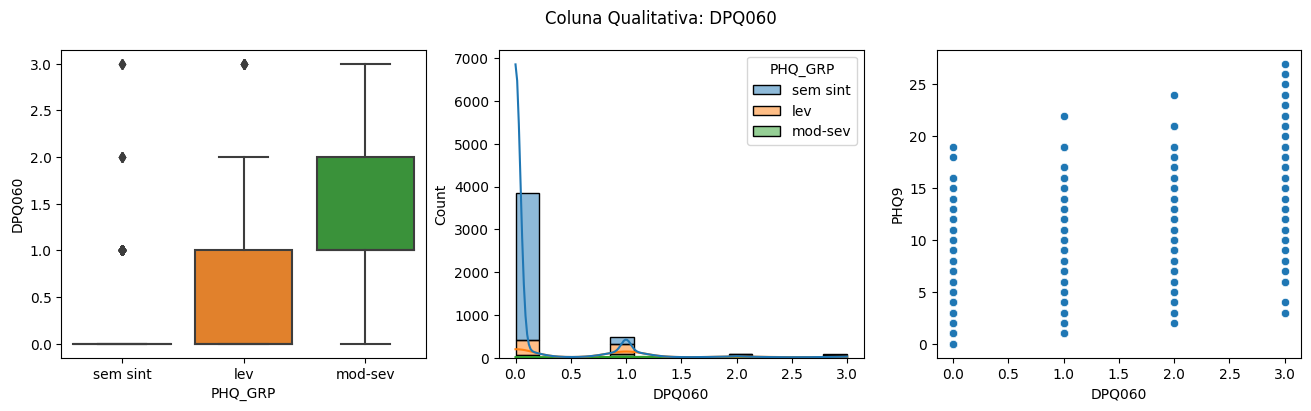

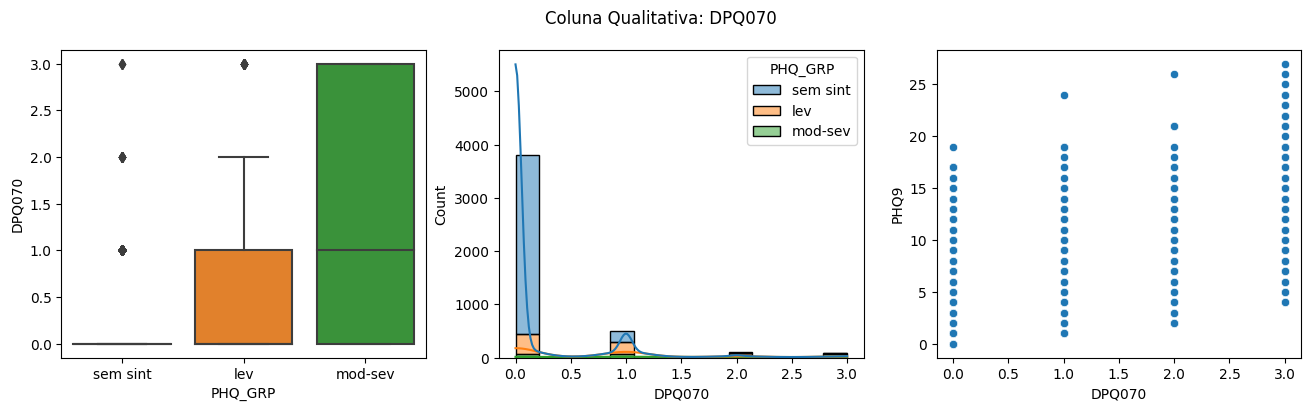

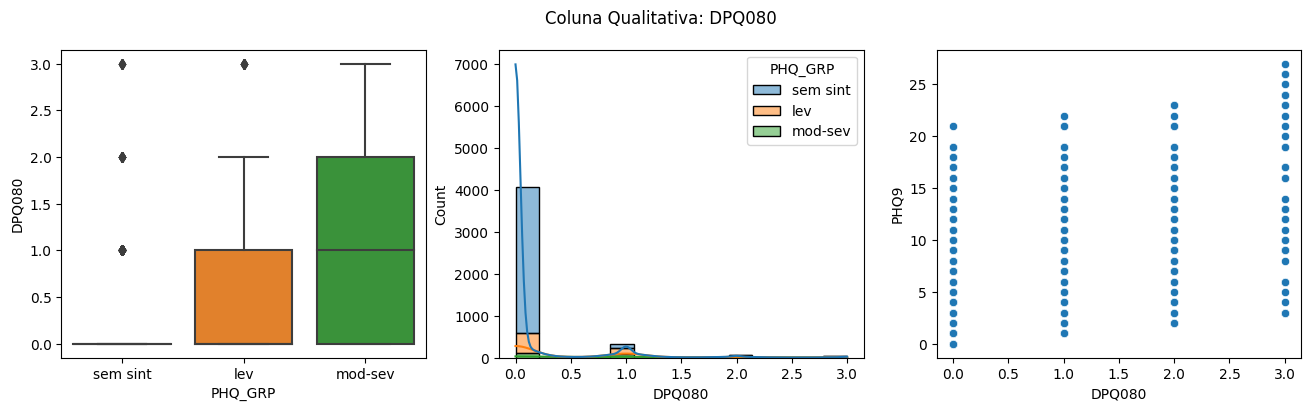

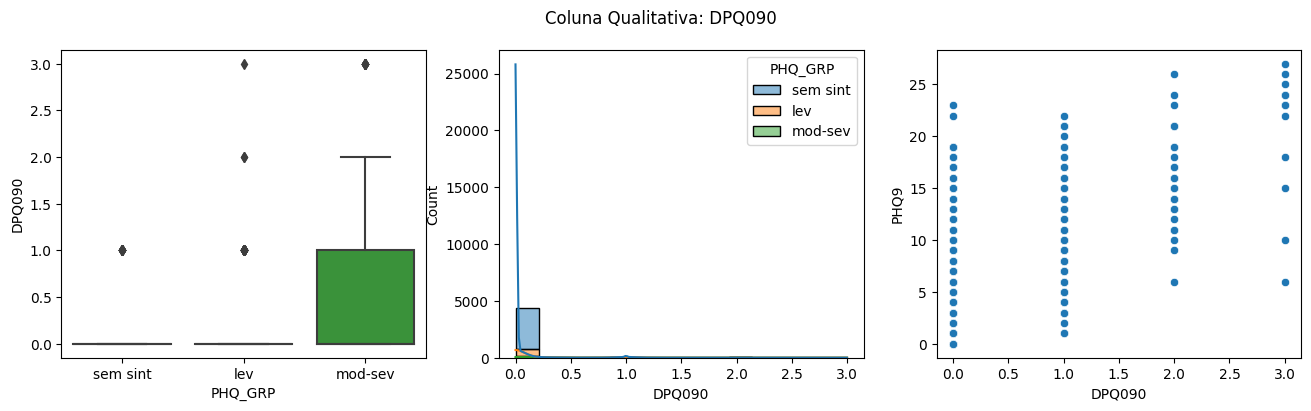

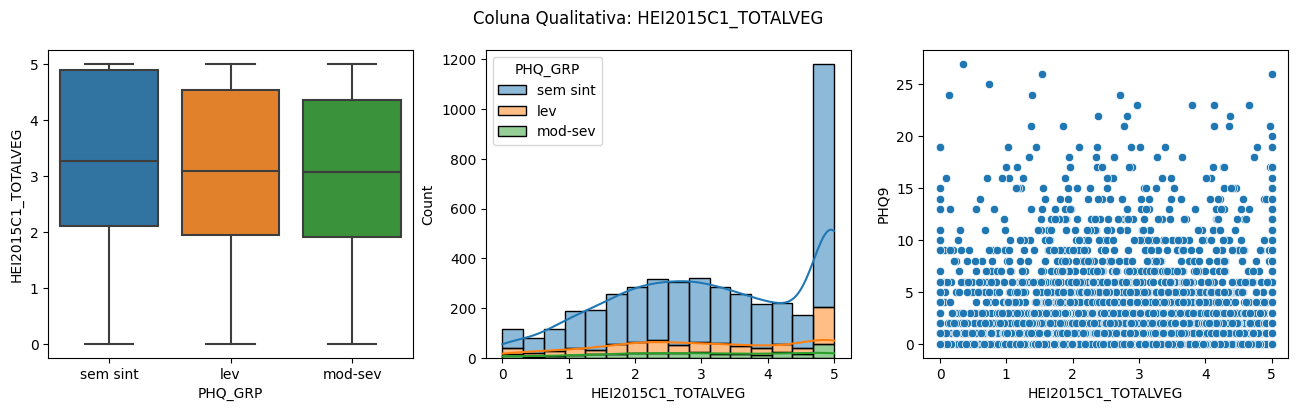

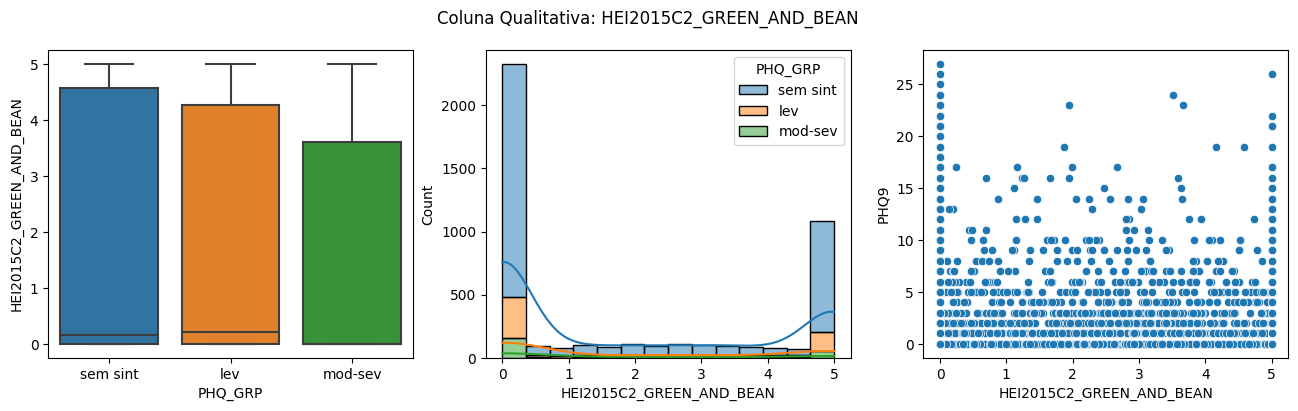

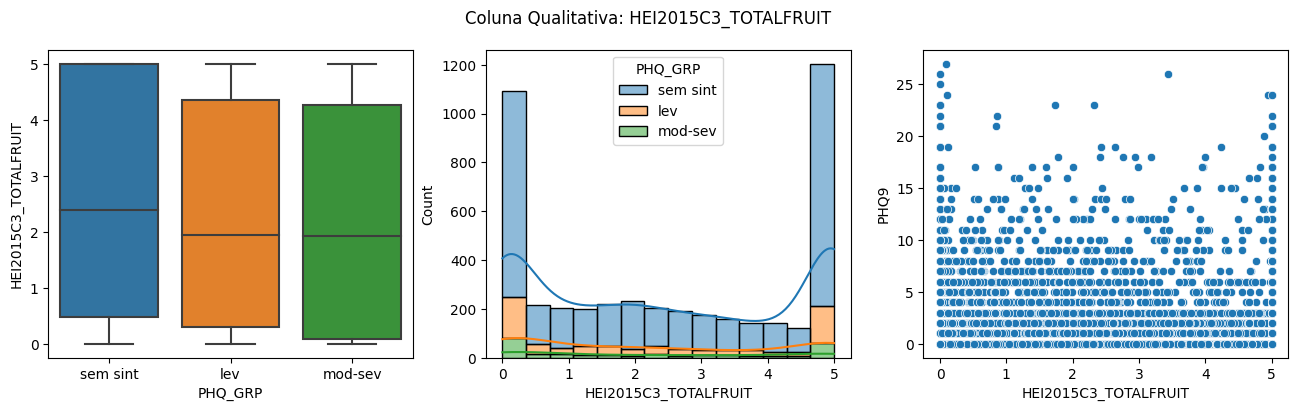

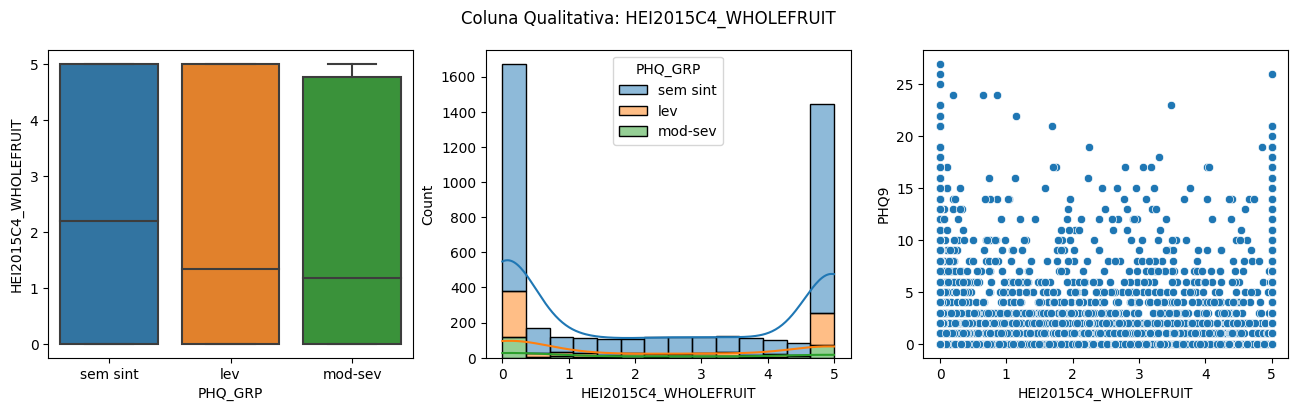

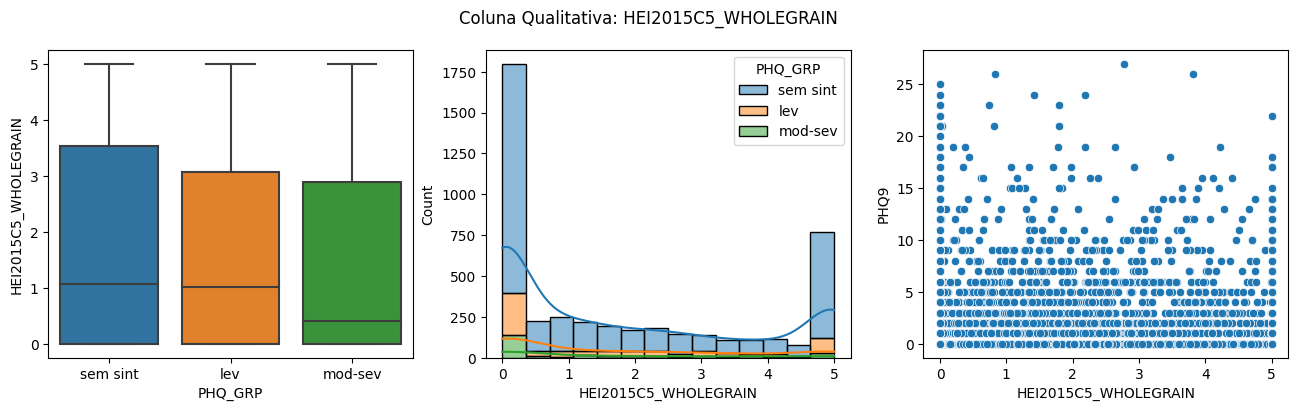

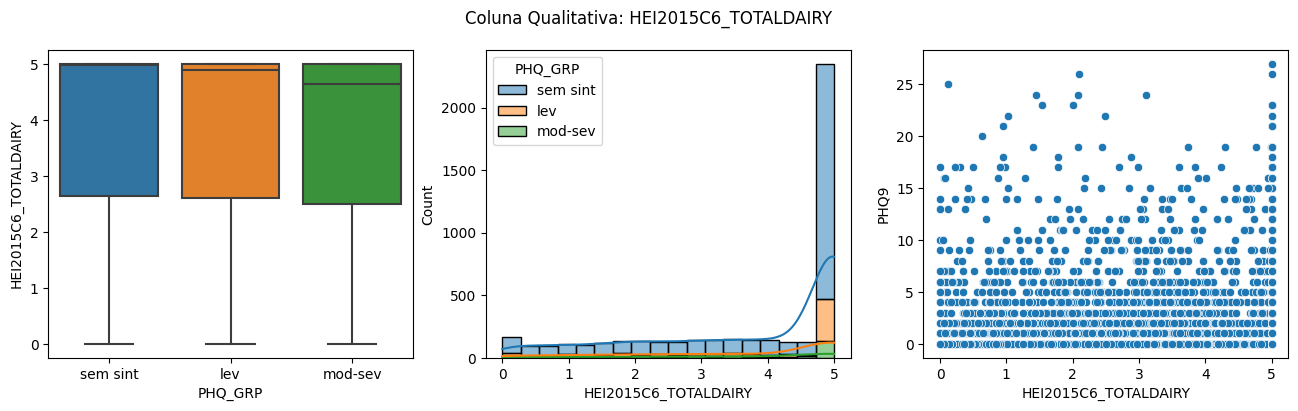

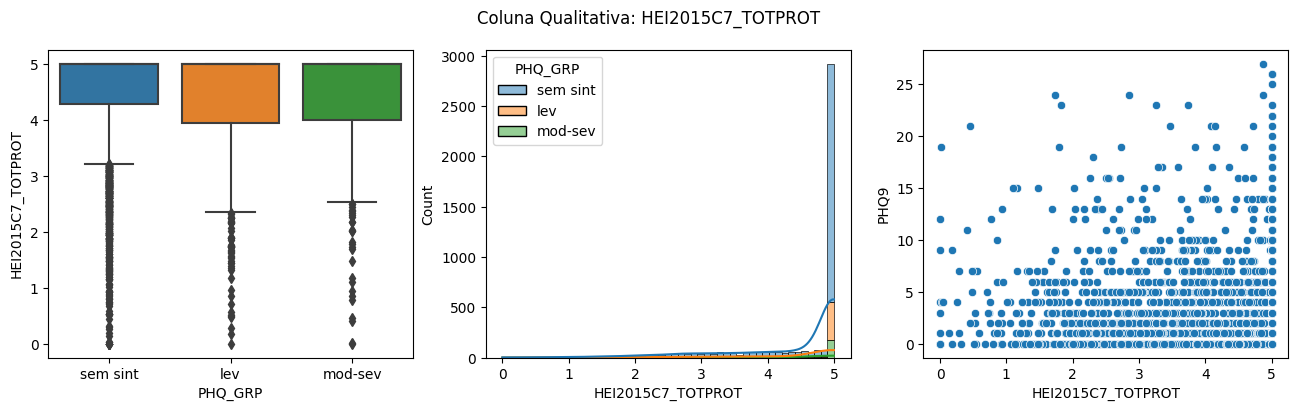

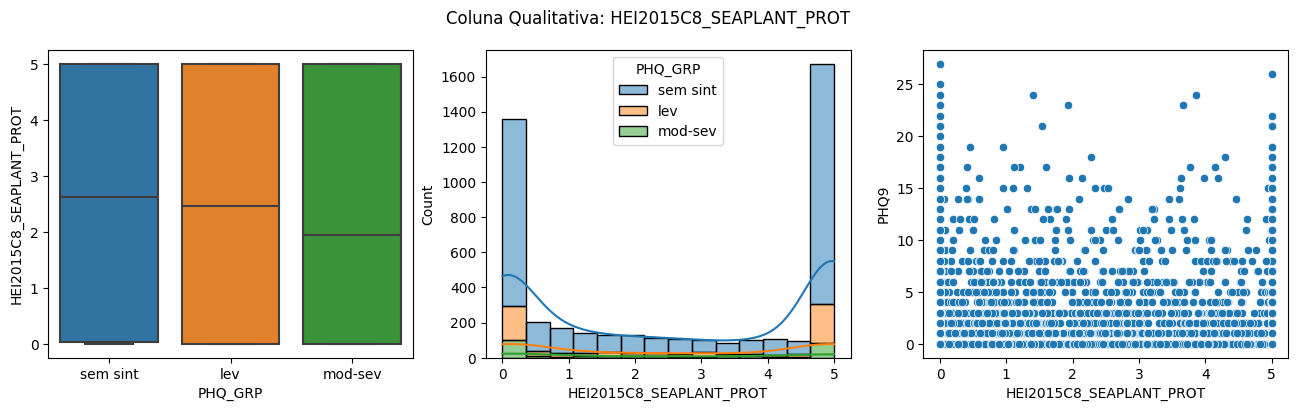

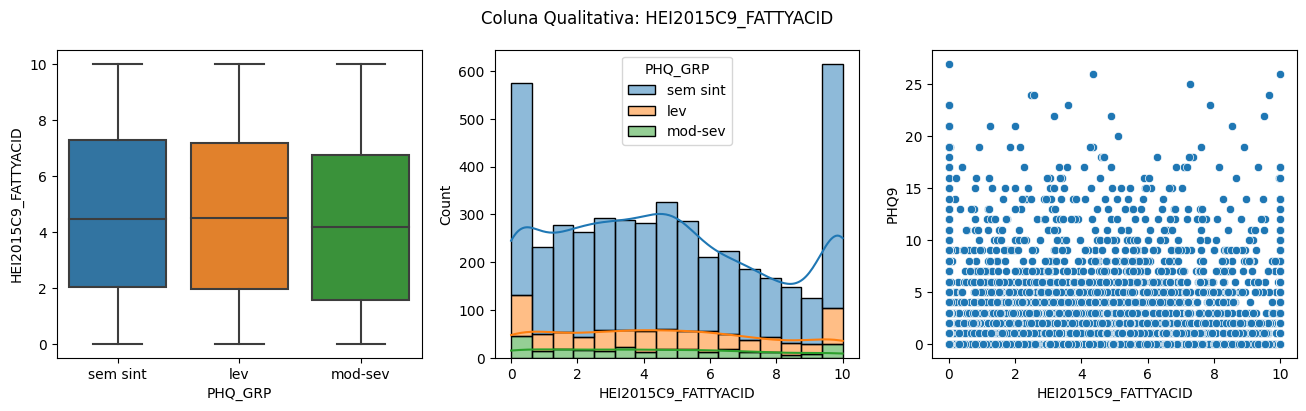

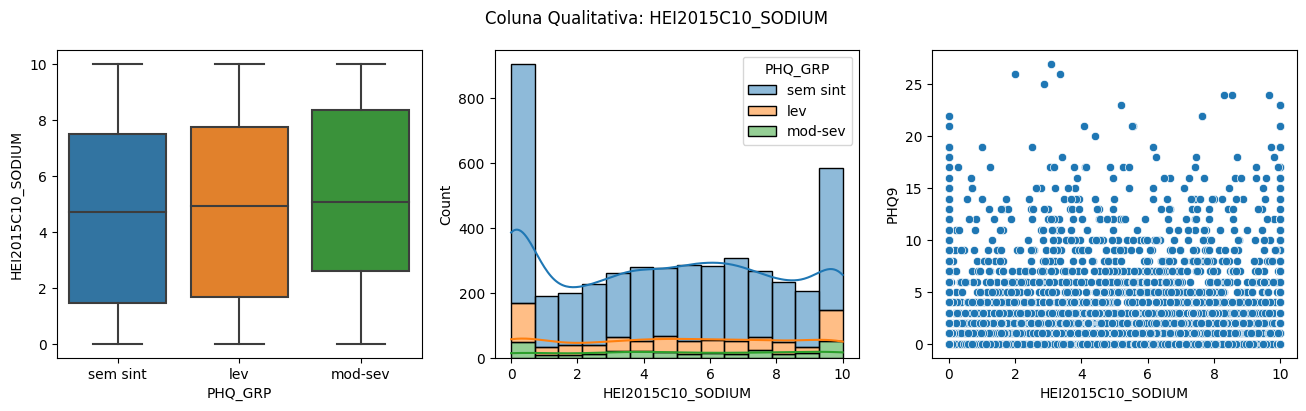

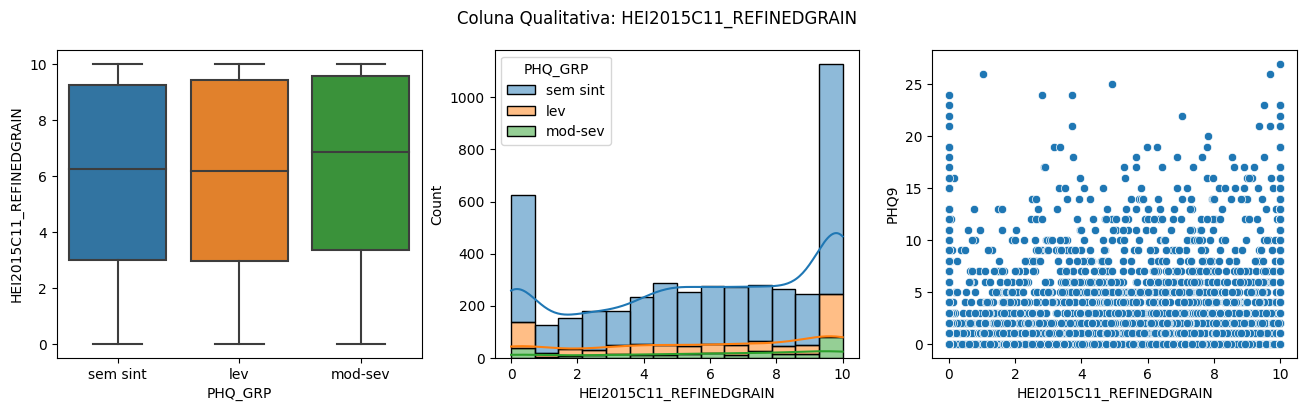

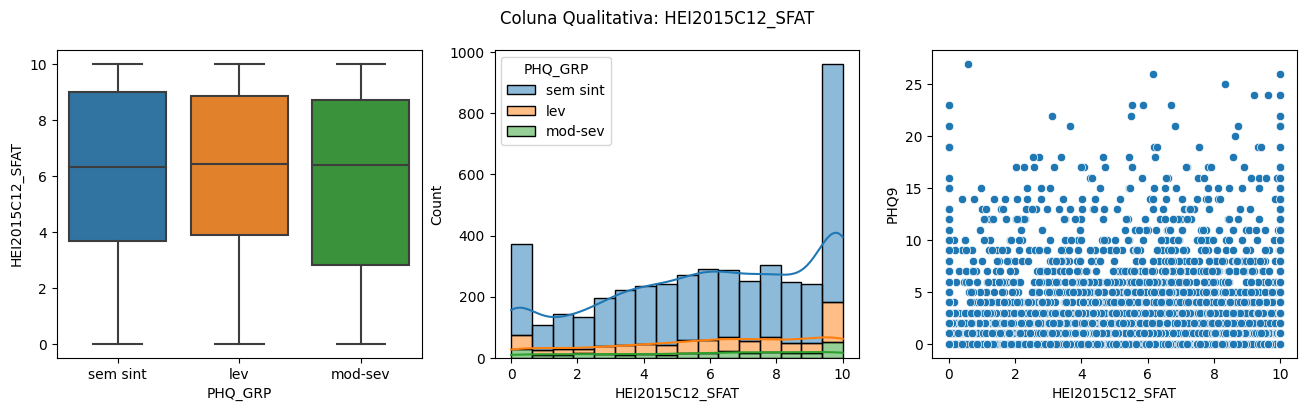

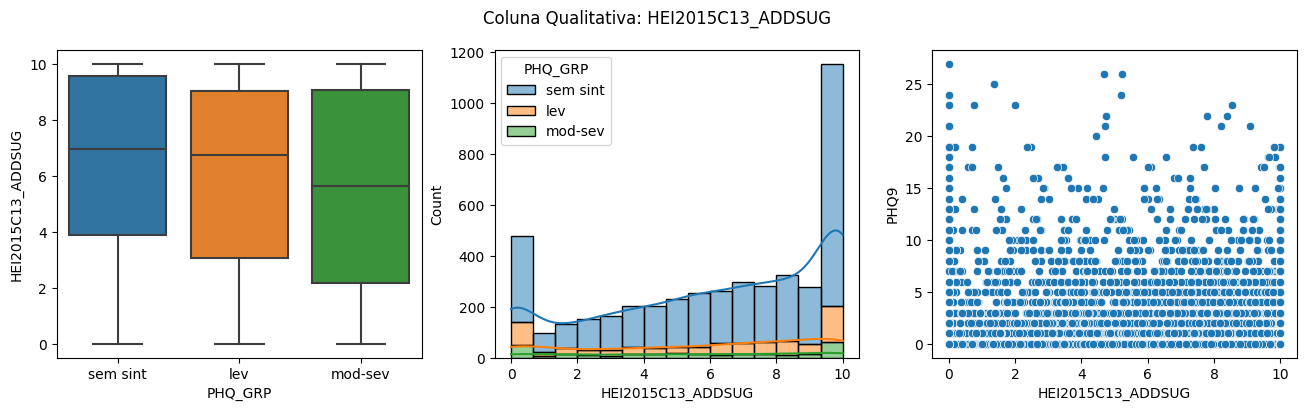

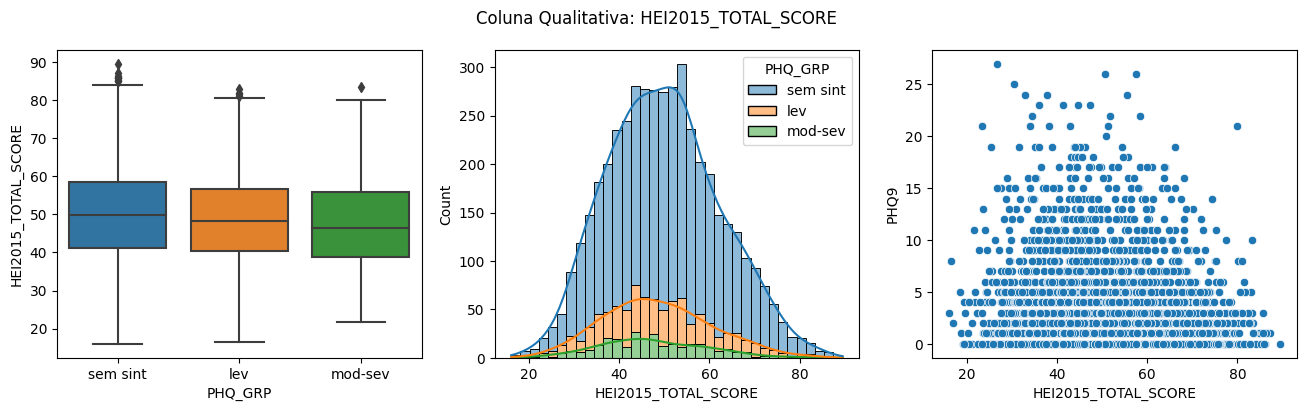

In [29]:
for col in quanti_cols:
    quanti_comparison(df, col, quali_ref, quanti_ref)